# Machine learning model creation and Interpretability

In this notebook, we are going to understand the following concepts with help fo credit details data set.
1. Data Quality & Data Cleaning
2. Feature Selection
3. Model Creation
4. Model Testing
5. Model Interpretability

Dataset link: https://www.kaggle.com/datasets/parisrohan/credit-score-classification

## Imports

In [237]:
import warnings
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder as le
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import RobustScaler as rbScaler 
from sklearn.linear_model import LogisticRegression as lgrClassifier
from sklearn import metrics

from statsmodels.stats.outliers_influence import variance_inflation_factor

warnings.filterwarnings('ignore')
%matplotlib inline

In [238]:
df = pd.read_csv('train.csv', low_memory=False)
df.shape

(5000, 29)

In [239]:
df.head()

,Unnamed: 0,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,98543,0x25765,CUS_0x9209,August,Richwinet,29,#F%$D@*&8,Architect,60529.08,5069.090000,...,_,2329.34,29.767865,16 Years and 5 Months,NM,317.580668,93.93216270640521,High_spent_Large_value_payments,335.396169432462,Poor
1,11895,0x5bb1,CUS_0x512d,August,Honanq,16,291-73-4587,Engineer,83075.64,7015.970000,...,Standard,1466.97,30.769814,24 Years and 0 Months,Yes,56.763754,183.71876611108243,Low_spent_Large_value_payments,731.1144798941579,Standard
2,41820,0x10b0a,CUS_0x7e51,May,Samuel Shenh,41,272-41-5715,Mechanic,13986.835,1411.569583,...,_,482.88,34.246971,16 Years and 3 Months,No,20.527575,124.42361207472136,Low_spent_Small_value_payments,286.2057708702884,Standard
3,73714,0x1c5ec,CUS_0x787f,March,Steve Slaters,22,401-83-7671,Scientist,25208.64,NaN,...,_,173.09,30.278265,29 Years and 7 Months,No,70.075923,153.54168182295254,Low_spent_Large_value_payments,281.654395280028,Standard
4,33534,0xda7c,CUS_0x14f5,July,Richard Leongd,41,497-15-6333,Doctor,36348.06,3265.005000,...,_,4974.81,24.653674,3 Years and 10 Months,Yes,149.399918,102.83187154218132,High_spent_Medium_value_payments,324.2687102598266,Poor


In the above dataset, we have credit details of a person such as **In_Hand_Salary**, **Number_Of_Bank_Accounts**, **credi_Mix**. With the help of all such columns it is possible to predict the amount investment monthly.

## Target variable is Amount_invested_monthly

## Data Quality & Cleaning

Before data analysis and model creation, we have to check the data issues such as missing values.

In [240]:
num_cols = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
       'Total_EMI_per_month', 'Amount_invested_monthly',
       'Monthly_Balance', 'Credit_History_Age']

categorical_cols = ['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount',
       'Payment_Behaviour', 'Credit_Score']

In [241]:
irrelavent_coulumns = ['ID', 'Customer_ID', 'Month', 'Name', 'SSN']
df.drop(columns=irrelavent_coulumns, inplace=True, axis=1)

In [242]:
df = df.applymap(
    lambda x: x if x is np.NaN or not \
        isinstance(x, str) else str(x).strip('_')).replace(
            ['', 'nan', '!@9#%8', '#F%$D@*&8'], np.NaN
        )

In [243]:
df.Age = df.Age.astype(int)
df.Annual_Income = df.Annual_Income.astype(float)
df.Num_of_Loan = df.Num_of_Loan.astype(int)
df.Num_of_Delayed_Payment = df.Num_of_Delayed_Payment.astype(float)
df.Changed_Credit_Limit = df.Changed_Credit_Limit.astype(float)
df.Outstanding_Debt = df.Outstanding_Debt.astype(float)
df.Amount_invested_monthly = df.Amount_invested_monthly.astype(float)
df.Monthly_Balance = df.Monthly_Balance.astype(float)

Above three steps involves the following tasks

1. We have dropped irrelavent columns for the task that we are working

2. Removed some of the junk characters from the data

3. Tranformed few columns which are identified as a wrong data types by the pandas

In [244]:
def take_years(x):  
    if x is not None:
        return str(x).strip()[0:2]

df.Credit_History_Age=df.Credit_History_Age.apply(take_years)
df['Credit_History_Age'] = df['Credit_History_Age'].replace({'na': np.NaN})

Credit history age is in the sentence form in the dataset, with the above code we are going to store only the year value.

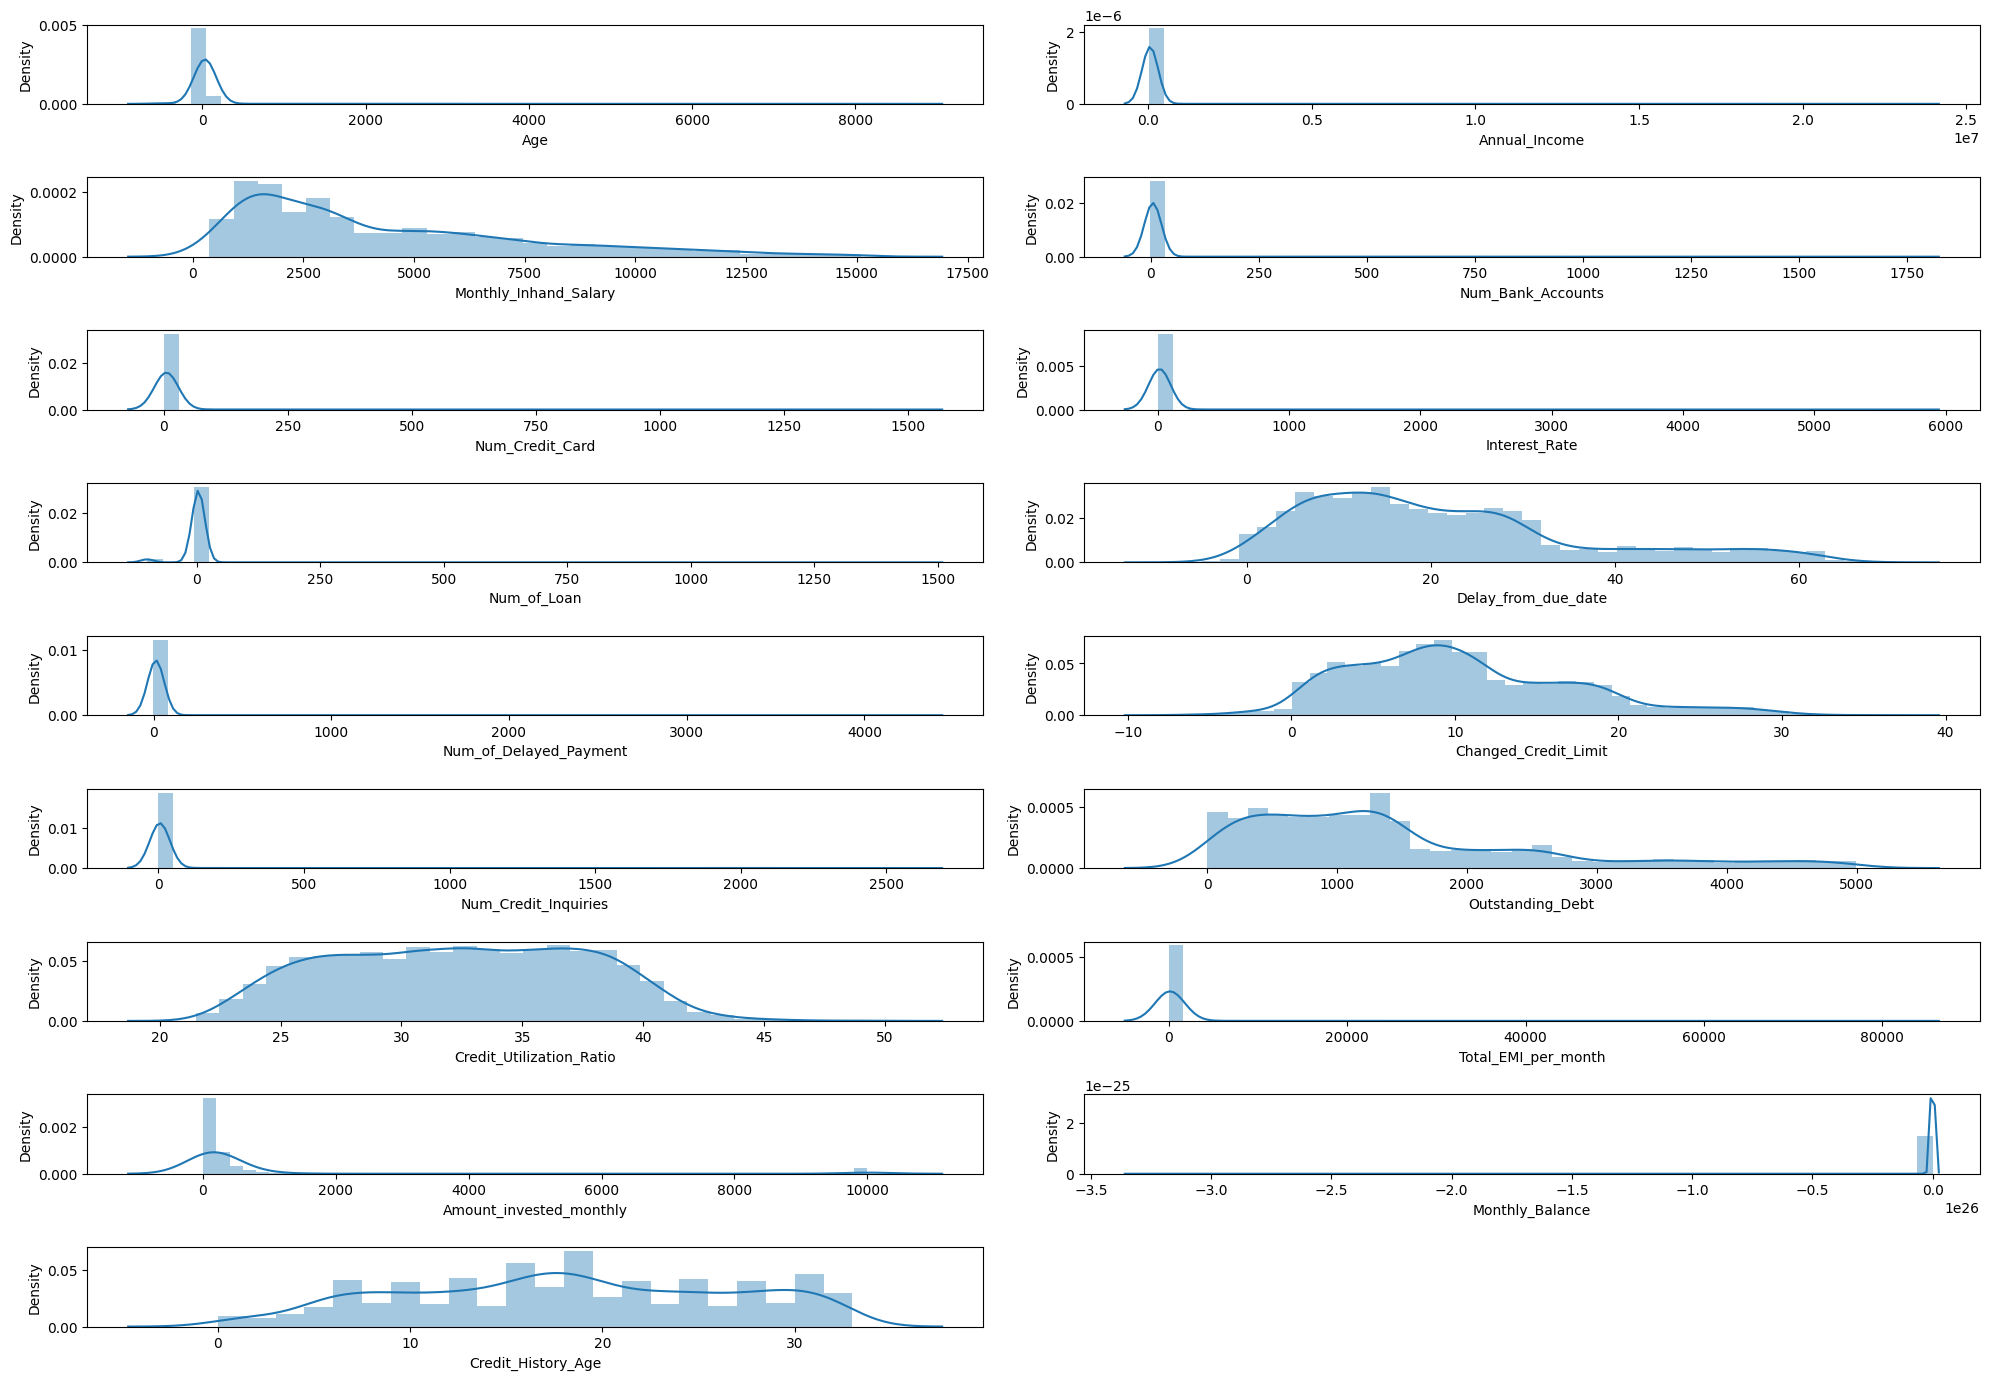

In [245]:
rows=10
cols=2
counter=1
plt.rcParams['figure.figsize']=[20, 15]
for i in num_cols:
    plt.subplot(rows, cols, counter)
    sns.distplot(df[i])
    counter+=1
plt.tight_layout()
plt.show()

Credit_Utilization_Ratio follows normal distribution

Delay_from_due_data is right skewed

Changed_Credit_Limit distribution looks fine, close to normal distribution

Outstanding_Debt is right skewed

Monthly_Inhand_Salary is right skewed

Credit_History_age is normally distributed

And all thre remaining fields contains outliers, because of that we are not able to properly distibute them with very less bins, lets try to remove outliers from those columns and replot them later.

### Distributions for the categorical columns


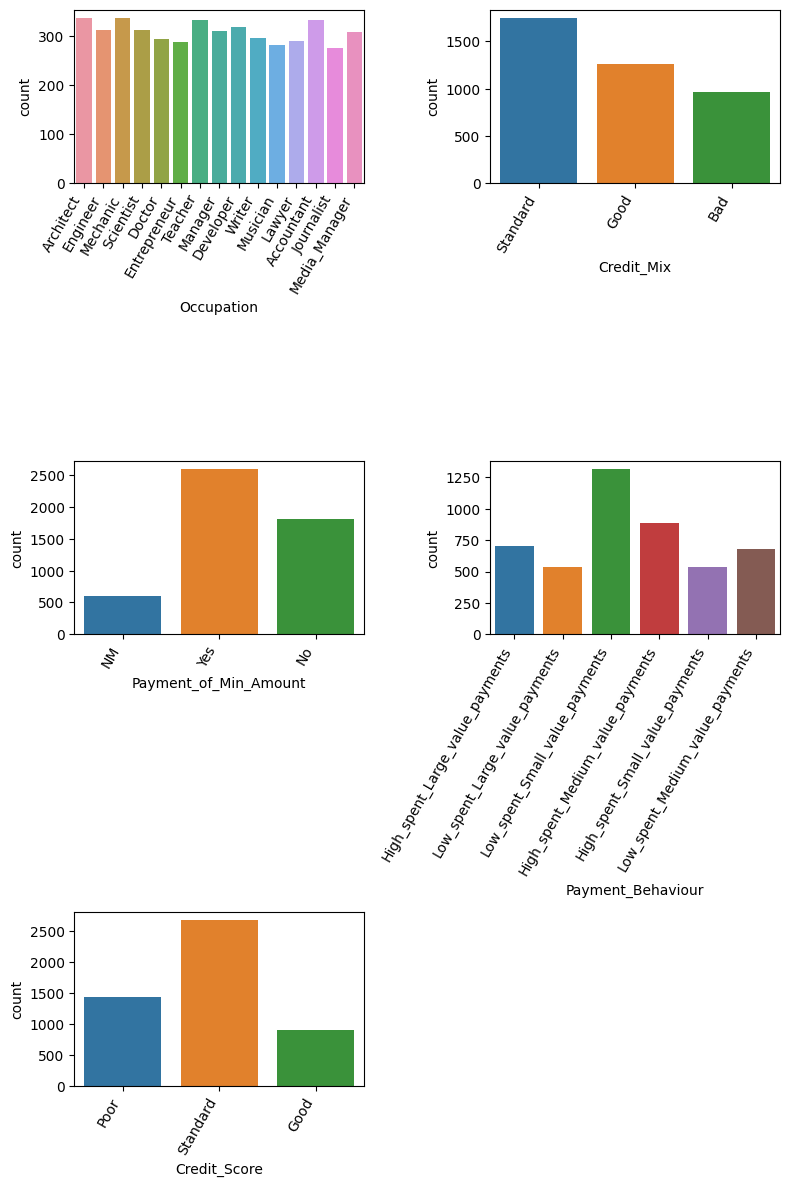

In [246]:
rows=3
cols=2
counter=1
plt.rcParams['figure.figsize']=[8, 12]
for i in categorical_cols:
    plt.subplot(rows,cols,counter)
    sns.countplot(x=i,data=df)
    plt.xticks(rotation=60,ha='right')
    counter+=1
plt.tight_layout()
plt.show()

All the categorical columns have the equal distribution of data except Payment_Behavious and Credit_Score

Occupation column has mix of rows from the various job roles

Credit_Mix column data is spreaded across three categories

Payment_of_Min_Amount column has data from both Yes and No categories, but there is one more category 'NM' which might need to be tranformed into 'No' as it might have been entered as a typo or pre-processing error in the upstream.

Payment_behaviour coulmn has more data with the "Low_spent_small_values" category

Credit_Score which is our target has a mix of good, bad and standard credit classification values

In [247]:
df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].replace({'NM': 'No'})

Plotting the **Payment_of_Min_Amount** after replacing it with proper value

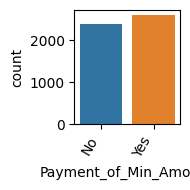

In [248]:
plt.rcParams['figure.figsize'] = [2,2]
sns.countplot(x='Payment_of_Min_Amount', data=df)
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

In [249]:
%%capture
def remove_outlier(df):
    low = .05
    high = .95
    quant_df = df.quantile([low, high])
    print(quant_df)
    for name in list(df.columns):
        if is_numeric_dtype(df[name]):
            df = df[(df[name] > quant_df.loc[low, name]) & (df[name] < quant_df.loc[high, name])]
    return df

df = remove_outlier(df)

All the extrment outliers are being removed from the dataset with the above function

In [250]:
Occupation_le = le()
Type_of_Loan_le = le()
Credit_Mix_le = le()
Credit_History_Age_le = le()
Payment_of_Min_Amount_le = le()
Payment_Behaviour_le = le()
Credit_Score_le = le()

df['Occupation'] = Occupation_le.fit_transform(df['Occupation'])
df['Type_of_Loan'] = Type_of_Loan_le.fit_transform(df['Type_of_Loan'])
df['Credit_Mix'] = Credit_Mix_le.fit_transform(df['Credit_Mix'])
df['Credit_History_Age'] = Credit_History_Age_le.fit_transform(df['Credit_History_Age'])
df['Payment_of_Min_Amount'] = Payment_of_Min_Amount_le.fit_transform(df['Payment_of_Min_Amount'])
df['Payment_Behaviour'] = Payment_Behaviour_le.fit_transform(df['Payment_Behaviour'])
df['Credit_Score'] = Credit_Score_le.fit_transform(df['Credit_Score'])

In the above code, we are encoding the categorical columns using Label Encoder(LE). LE is one of the techique which can be used to encode the categocrical features to numnerical. LE encodes the features from 0 to n-1 classes where n is number of distinct classes. 

### Correlation heatmap

<AxesSubplot: >

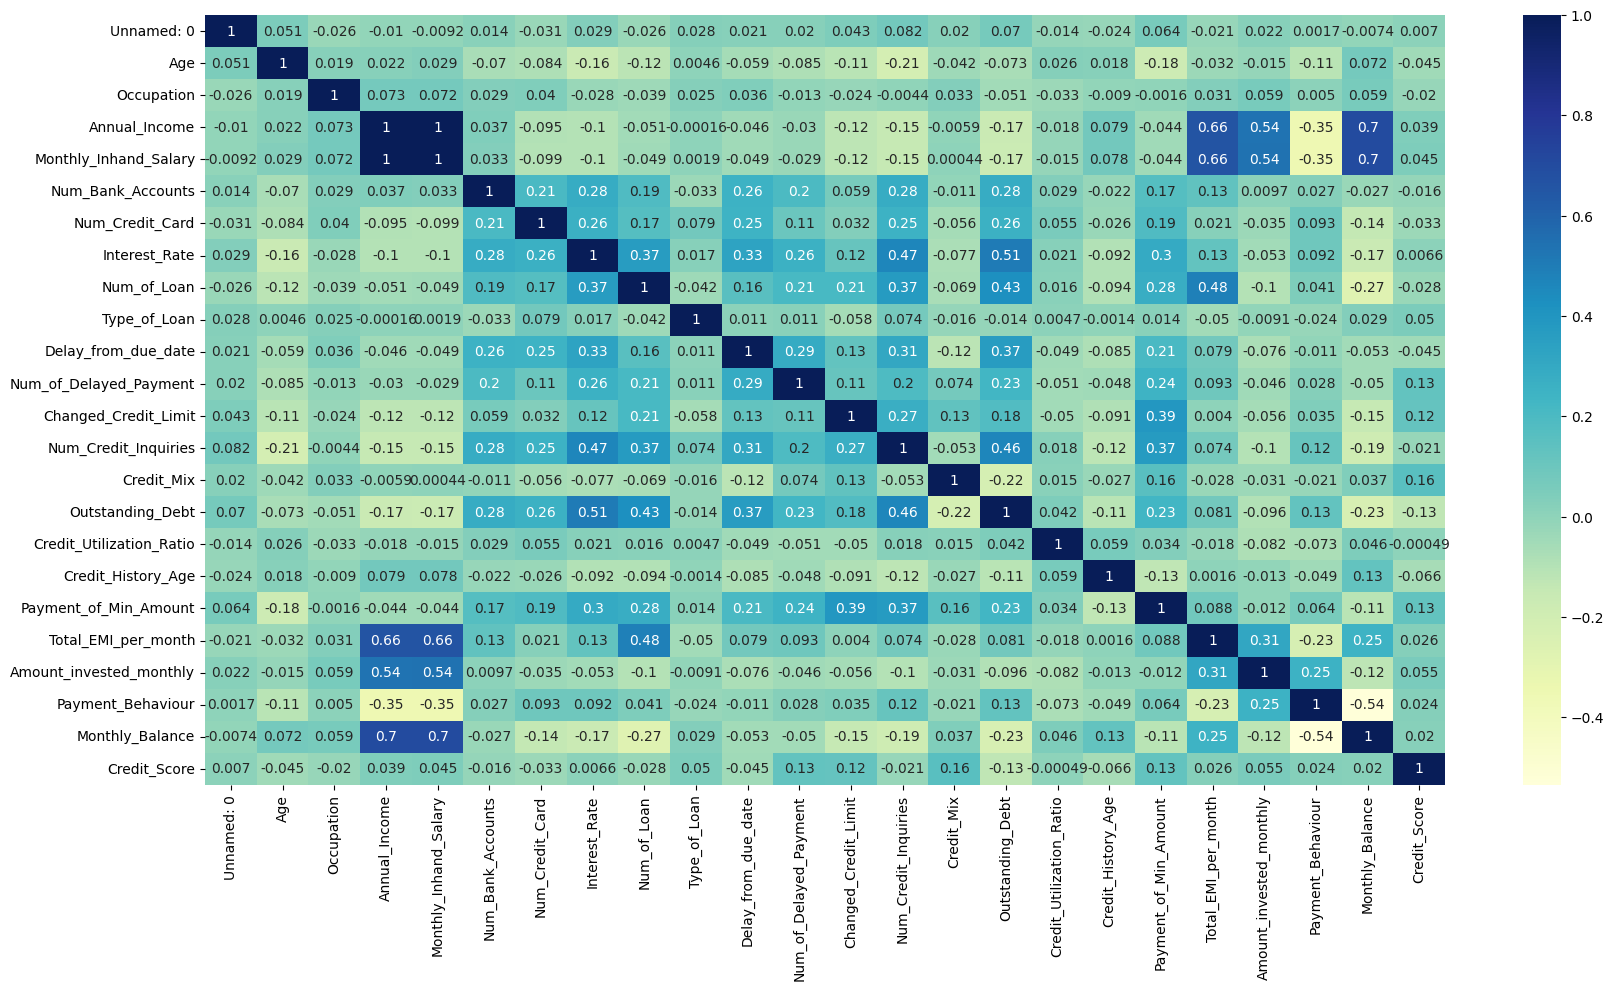

In [251]:
plt.figure(figsize = (20,10))
sns.heatmap(df.corr() , annot = True, cmap = "YlGnBu")

The correlation heatmap is basic tool to understand the correlation between all the features in a dataset. It also has an option to display the correlation coefficients which helps to easily summurize the large set of features and understand the patterns.

From the above correlation heatmap, we can clearly see that, our target feature Amount_Invested_Monthly is highly correlated with **Annual_Income** and **Monthly_Inhand_Salary** and negatively correlated with Num_Credit_Inquiries

### Feature Selection

In [252]:
round(abs(df.corr()['Amount_invested_monthly']*100).sort_values(ascending=False), 2)

Amount_invested_monthly     100.00
Monthly_Inhand_Salary        54.16
Annual_Income                53.66
Total_EMI_per_month          31.33
Payment_Behaviour            25.30
Monthly_Balance              12.33
Num_Credit_Inquiries         10.18
Num_of_Loan                  10.06
Outstanding_Debt              9.61
Credit_Utilization_Ratio      8.23
Delay_from_due_date           7.63
Occupation                    5.89
Changed_Credit_Limit          5.61
Credit_Score                  5.53
Interest_Rate                 5.34
Num_of_Delayed_Payment        4.65
Num_Credit_Card               3.54
Credit_Mix                    3.15
Unnamed: 0                    2.18
Age                           1.52
Credit_History_Age            1.25
Payment_of_Min_Amount         1.24
Num_Bank_Accounts             0.97
Type_of_Loan                  0.91
Name: Amount_invested_monthly, dtype: float64

<AxesSubplot: >

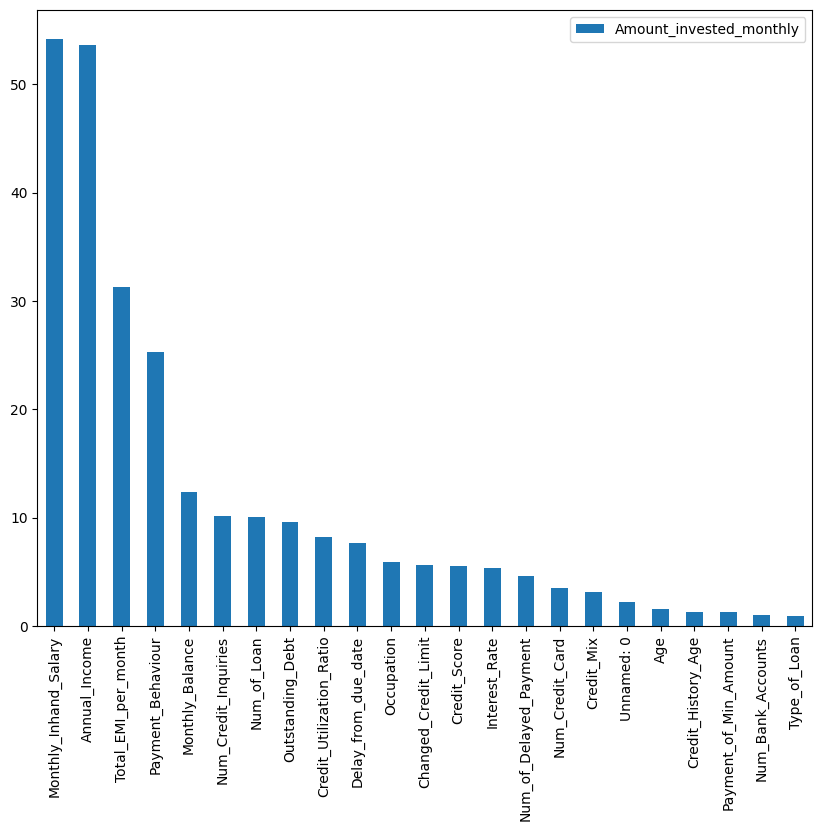

In [253]:
pd.DataFrame(abs(df.corr()['Amount_invested_monthly'].drop('Amount_invested_monthly')*100).sort_values(
    ascending=False)).plot.bar(figsize = (10,8))

In [254]:
numeric_cols = df.select_dtypes(exclude = "object").columns

vif_df = df[numeric_cols]
vif_data = pd.DataFrame()
vif_data["feature"] = vif_df.columns
vif_data["VIF"] = [variance_inflation_factor(vif_df.values ,i) for i in range(len(vif_df.columns))]
vif_data.head(17)

,feature,VIF
0,Unnamed: 0,5.341169
1,Age,13.129838
2,Occupation,3.580755
3,Annual_Income,757.615059
4,Monthly_Inhand_Salary,887.680393
5,Num_Bank_Accounts,11.765425
6,Num_Credit_Card,21.374806
7,Interest_Rate,9.201964
8,Num_of_Loan,11.648395
9,Type_of_Loan,4.138574


In [255]:
%%capture
df.drop("Annual_Income", axis=1)
df.drop("Num_Credit_Card", axis=1)
df.drop("Credit_Utilization_Ratio", axis=1)

## Modeling

In [256]:
X = df.drop(['Amount_invested_monthly'] , axis = 1)
y = df['Amount_invested_monthly' ]

In [257]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [258]:
import statsmodels.api as sm

linear_model = sm.OLS(y_train, X_train).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     Amount_invested_monthly   R-squared (uncentered):                   0.985
Model:                                 OLS   Adj. R-squared (uncentered):              0.985
Method:                      Least Squares   F-statistic:                              1354.
Date:                     Thu, 15 Dec 2022   Prob (F-statistic):                        0.00
Time:                             23:54:22   Log-Likelihood:                         -2267.4
No. Observations:                      484   AIC:                                      4581.
Df Residuals:                          461   BIC:                                      4677.
Df Model:                               23                                                  
Covariance Type:                 nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Unnamed: 0                   0.0001   4.96e-05      2.851      0.005    4.39e-05       0.000
Age                          0.8543      0.126      6.779      0.000       0.607       1.102
Occupation                   0.4939      0.263      1.875      0.061      -0.024       1.012
Annual_Income                0.0003      0.001      0.537      0.592      -0.001       0.002
Monthly_Inhand_Salary        0.0925      0.007     12.558      0.000       0.078       0.107
Num_Bank_Accounts            1.7888      0.706      2.533      0.012       0.401       3.177
Num_Credit_Card              4.6179      0.974      4.743      0.000       2.705       6.531
Interest_Rate                0.4210      0.246      1.709      0.088      -0.063       0.905
Num_of_Loan                 -1.8508      1.143     -1.619      0.106      -4.097       0.396
Type_of_Loan                 0.0250      0.011      2.261      0.024       0.003       0.047
Delay_from_due_date          0.1123      0.145      0.773      0.440      -0.173       0.398
Num_of_Delayed_Payment       1.0856      0.296      3.672      0.000       0.505       1.667
Changed_Credit_Limit         1.3500      0.270      4.998      0.000       0.819       1.881
Num_Credit_Inquiries        -0.4464      0.540     -0.826      0.409      -1.508       0.615
Credit_Mix                   3.1421      1.712      1.835      0.067      -0.223       6.507
Outstanding_Debt            -0.0045      0.002     -2.082      0.038      -0.009      -0.000
Credit_Utilization_Ratio     2.8901      0.234     12.364      0.000       2.431       3.349
Credit_History_Age           0.2754      0.125      2.210      0.028       0.031       0.520
Payment_of_Min_Amount       -6.2726      3.041     -2.063      0.040     -12.249      -0.296
Total_EMI_per_month         -0.8757      0.034    -26.070      0.000      -0.942      -0.810
Payment_Behaviour           13.0817      0.722     18.123      0.000      11.663      14.500
Monthly_Balance             -0.9497      0.014    -69.140      0.000      -0.977      -0.923
Credit_Score                 4.9845      1.845      2.702      0.007       1.360       8.609
==============================================================================
Omnibus:                      175.415   Durbin-Watson:                   1.837
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1898.611
Skew:                           1.247   Prob(JB):                         0.00
Kurtosis:                      12.377   Cond. No.                     1.87e+05
==============================================================================

Notes:
[1] R² is computed without ce

**R-squared**: r-squared is the statistic which explains the goodness of a fit. Its values ranges from 0 to 1. In the above model, the r-squared value is 0.97 which means the model has explained the 97 percent of the model variance.

**p-value** is how statistically significant the variable to the model for confidence level of 95 percent. We will compare the p-value with alpha 0.05, in our case p-value of Montly_Inhand_Salary, Num_Bank_Accounts etc,. are less than alpha, this implies that all are statistically significant to our model except few columns such as Interest_Rate, Occupation. The below function will display all the features which statistically significant.

In [259]:
def pValueCheck(b):
    if b < 0.05:
        return 'Yes'
    else:
        return 'No'

df_result=pd.DataFrame()
df_result['pvalues']=linear_model.pvalues[1:]
df_result['Statistically significant?']= df_result['pvalues'].apply(pValueCheck)
df_result

,pvalues,Statistically significant?
Age,3.704070e-11,Yes
Occupation,6.142773e-02,No
Annual_Income,5.917419e-01,No
Monthly_Inhand_Salary,2.576726e-31,Yes
Num_Bank_Accounts,1.164961e-02,Yes
Num_Credit_Card,2.816180e-06,Yes
Interest_Rate,8.815341e-02,No
Num_of_Loan,1.061109e-01,No
Type_of_Loan,2.423843e-02,Yes
Delay_from_due_date,4.399803e-01,No


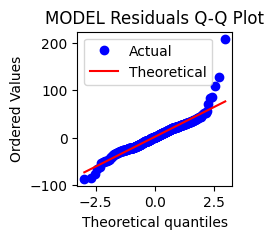

In [260]:
from scipy import stats
stats.probplot(linear_model.resid, dist="norm", plot= plt)
plt.title("MODEL Residuals Q-Q Plot")
plt.legend(['Actual','Theoretical'])

As per the QQ-plot, there is no skewness in data.

### Heteroscedasticity Test:

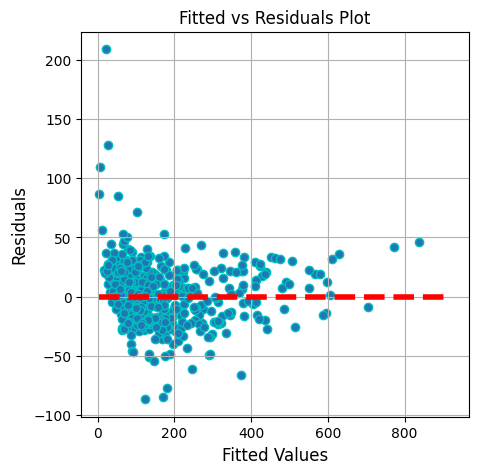

In [261]:
plt.figure(figsize=(5,5))
p=plt.scatter(x=linear_model.fittedvalues, y=linear_model.resid, edgecolor='c')
xmin=min(linear_model.fittedvalues)
xmax = max(linear_model.fittedvalues)
plt.hlines(y=0, xmin=xmin*0.9, xmax=xmax*1.1, color='red', linestyle='--', lw=4)
plt.xlabel("Fitted Values",fontsize=12)
plt.ylabel("Residuals",fontsize=12)
plt.title("Fitted vs Residuals Plot", fontsize=12)
plt.grid(True)
plt.show()

The fitted vs. residuals plot shows violation of the constant variance assumption, in the above plot, we can see that, most of the residuals followed the constant variance.

# Model interpretation

We are going to perform the model interpretation with the help of `shap` python module

In [262]:
import shap
shap.initjs()

## Local interpretability

Local interpretability is interpreation of individual prediction.

### Force Plot Analysis

Force plot helps to visualize how features contribute the individual predictions, lets check the force plot for the row index 5, i.e, 5th row in the X_test.

#### Linear Model Analysis

In [263]:
linear_shap_explainer = shap.Explainer(linear_model.predict, X_test)
linear_model_shap_values = linear_shap_explainer(X_test)

In [264]:
shap.plots.force(linear_model_shap_values[5])

In this case, feature **"Monthly_inhand_salary"** have a positive impact on the prediction, while **"Total_EMI_per_month"** have a negative impact on the prediction. It tells us that that, the person with a good salary was able to save most in a month.

### Global interpretability

Global interpretability helps to interpret the overall model.

#### Variable Importance

Variable Importance helps to understand the important features that contribute the accuracy of a model.

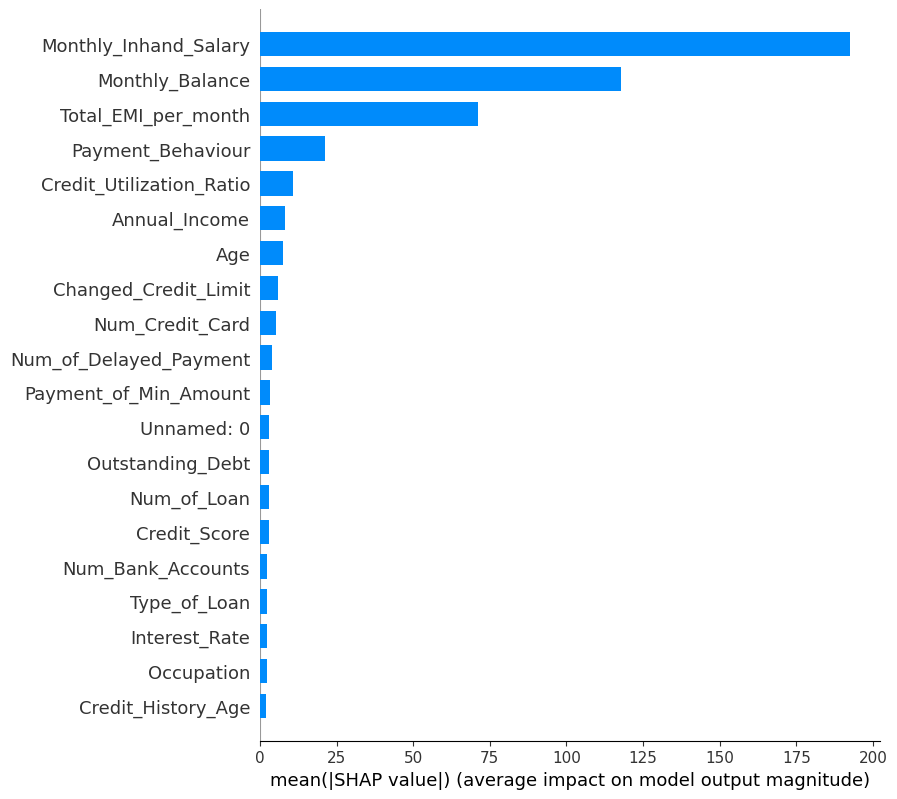

In [265]:
shap.summary_plot(linear_model_shap_values, X_test, plot_type="bar", show=False)


From the above three plots, we can clearly see that the Monthly_Inhand_salary is the feature which has contributed the most.

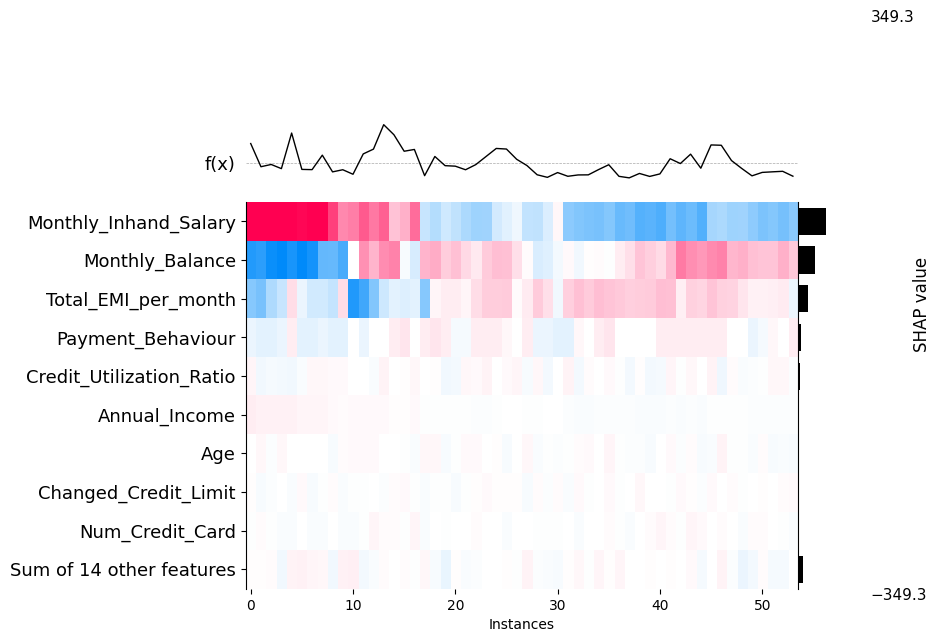

In [266]:
shap.plots.heatmap(linear_model_shap_values[0:1000])

This heatmap is based on samples from 0 to 1000. So the X-axis is the instance from 0 to 50. The colors show the magnitude of the SHAP values. Look at the instance 0 on the left of the heatmap, it has a red color for Monthly inhand salary, which means "Monthly inhand salary" has contributed the most to the Amount invested.

The f(x) curve on the top of Figure is the model predictions of the instances. Instances around 0 has a high prediction. It means the  Monthly inhand salary around 0 is high, and Amount investment is also high.

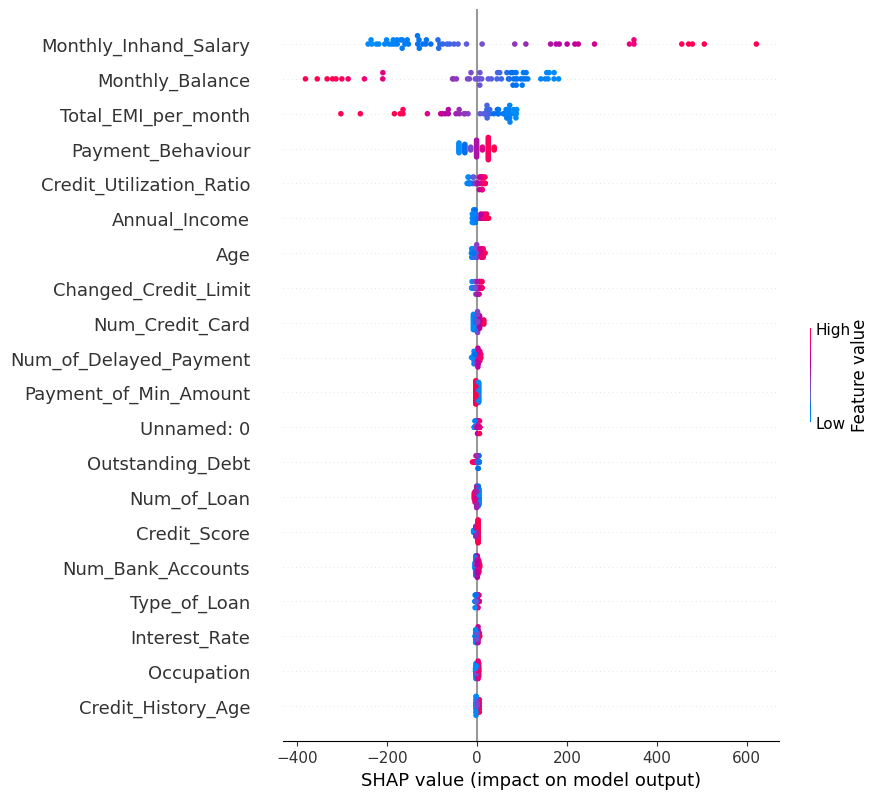

In [267]:
shap.summary_plot(linear_model_shap_values, X_test)

As per the above plot, 

High in hand salary contributed to the most savings.

Low monthly balance reduced the savings of an individual.

Total EMI per month also contributed to the monthly savings in a negative way.

### Questions:

#### 1. What is the question?

The questions is to predict the monthly investment value of a person based on his/her past credit history.

#### 2. What did you do?


I have created a linear model to solve this problem and checked for the assumptions of linear model such as check for the distribution with the help of QQ plot, homoscedasticity.

Once the model is created, I have used shap python module to understanbd the model performance.

#### 3. How well did it work?

R-square value 0.98, which tells us that the model performed really well.


#### 4. What did you learn?


Through these assignments, I learnt so many concepts in data science especially about the supervise machine learning topics. Few of them are as follows.

1. Data analysis such as missing values, outliers.
2. Model creation for continuos and class variables.
3. Model interpretability with the help of shap.
4. Model testing
5. CNN for image classification(not discussed in this assignment)

## Conclusion

Model r-square value is 0.98

Based on the model interpretation, 

High in hand salary contributed to the most savings, while Low monthly balance reduced the savings of an individual and Total EMI per month also contributed to the monthly savings in a neggative way.

## References

Refered the following links to understand the functions or the processes that are going to be required during the problem analysis.

1. Scikit-learn Documentation

2. Pandas Official Documentation

3. Analytics Vidya

4. medium: towardsdatascience

5. Seaborn: statistical data visualization

All the visualization code was referred form the seaborn and scikit-learn official documentations. Data frame functions and usage was referred from the Pandas official documentation. All the concepts and doubts in the machine learning cleared with the help of medium(towardsdatascience) and analytics vidya articles. Rest of the code is written individually. pep8 code was followed for all the code snippets.

## Copyright

Copyright 2022 Naga Venkatesh Gavini

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.